In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from gpytorch.kernels import RBFKernel
from grakel.kernels import WeisfeilerLehman
from gpytorch.priors import NormalPrior
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.models import GIN, GAT, GCN, GraphSAGE

from mobius import Planner, SequenceGA, Pool
from mobius import ProteinEmbedding
from mobius import InverseFolding
from mobius import GPLLModel, GPModel, GPGNNModel, GPGKModel
from mobius import ExpectedImprovement
from mobius import Graph, Map4Fingerprint
from mobius import TanimotoSimilarityKernel
from mobius import homolog_scanning
from mobius import convert_FASTA_to_HELM, convert_HELM_to_FASTA
from mobius.utils import MolFromHELM
from mobius.utils import generate_biopolymer_design_protocol_from_probabilities

## Initialize Thrombin oracle

Citation: De novo development of small cyclic peptides that are orally bioavailable; Merz et al.; 2024; https://doi.org/10.1038/s41589-023-01496-y

In [3]:
class ThrombinScorer:
    
    def __init__(self, sequences, values, HELM_extra_library_filename):
        if len(sequences) != len(values):
            raise ValueError(f'Different numbers of sequences and values ({len(sequences)} != {len(values)})')

        map4 = Map4Fingerprint(input_type='HELM', chiral=True, HELM_extra_library_filename=HELM_extra_library_filename)
        kernel = TanimotoSimilarityKernel()
        self._model = GPModel(kernel=kernel, transform=map4, noise_prior=NormalPrior(loc=0, scale=1))
        self._model.fit(sequences, values)

    def score(self, sequences):
        if not isinstance(sequences, (list, tuple, np.ndarray)):
            sequences = [sequences]
        
        return self._model.predict(sequences)[0]

In [4]:
df_exp = pd.read_csv('thrombin_dataset.csv')
tb = ThrombinScorer(df_exp['HELM'].values, df_exp['Residual thrombin activity'].values, 'library.json')

Fitting GP model (cuda): 25step [00:11,  2.25step/s, loss=3.49]


## Run Bayesian Optimization

## MAP4 chiral fingerprint

In [5]:
map4 = Map4Fingerprint(input_type='HELM', chiral=True, HELM_extra_library_filename='library.json')
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))

In [6]:
yaml_content = """
    design:
      monomers:
        BB-AA: [X21, X22, X23, X24, X25, X26, X27, X28, X29, X30]
        SD-AA: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10]
        Di-AA: [X11, X12, X13, X14, X15, X16, X17, X18, X19, X20]
        linkers: ['[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|', '[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|', '[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|', '[*]C/C=C/C[*] |$_R1;;;;;_R2$|']
        acids: [A5, A6, A7, A8, A9, A10, A11, A12, A13, A14]
        default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
      polymers:
        - CHEM1{X}|PEPTIDE1{X.C.X.X.[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0:
            CHEM1:
              1: linkers
            PEPTIDE1:
              1: acids
              3: [SD-AA, BB-AA]
              4: [SD-AA, BB-AA]
        - CHEM1{X}|PEPTIDE1{C.X.X.[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0:
            CHEM1:
              1: linkers
            PEPTIDE1:
              2: [SD-AA, BB-AA]
              3: [SD-AA, BB-AA]
        - CHEM1{X}|PEPTIDE1{[Mpa].X.X.[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0:
            CHEM1:
              1: linkers
            PEPTIDE1:
              2: Di-AA
              3: SD-AA
        - CHEM1{X}|PEPTIDE1{[Mpa].X.X.[Mea]}|PEPTIDE2{X}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0:
            CHEM1:
              1: linkers
            PEPTIDE1:
              2: Di-AA
              3: SD-AA
            PEPTIDE2:
              1: acids
        - CHEM1{X}|PEPTIDE1{[Mpa].X.X.[Mea]}$CHEM1,PEPTIDE1,1:R1-1:R3|PEPTIDE1,CHEM1,4:R3-1:R2$$$V2.0:
            CHEM1:
              1: linkers
            PEPTIDE1:
              2: SD-AA
              3: Di-AA
        - CHEM1{X}|PEPTIDE1{[Mpa].X.X.[Mea]}|PEPTIDE2{X}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0:
            CHEM1:
              1: linkers
            PEPTIDE1:
              2: SD-AA
              3: Di-AA
            PEPTIDE2:
              1: acids
    """
    
with open('design_protocol.yaml', 'w') as f:
    f.write(yaml_content)

In [7]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol.yaml')
ps = Planner(acq, optimizer)

In [8]:
# We start with the worst peptides
seed_library = df_exp['HELM'][-96:].values
scores_seed_library = df_exp['Residual thrombin activity'][-96:].values

In [9]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4C', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = tb.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4C', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4C_oracle.csv', index=False)

Fitting GP model (cuda): 26step [00:00, 131.90step/s, loss=2.77]
2024-10-02 13:54:29,792	INFO worker.py:1788 -- Started a local Ray instance.


(parallel_ga_gpu pid=1981791) ==========================================================================================================
(parallel_ga_gpu pid=1981791) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1981791) ==========================================================================================================
(parallel_ga_gpu pid=1981791)      1 |        0 |  2.3791606062315E+02 |  2.3430274733156E+02 | CHEM1{[[*]CS(=O)(=....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1981791)      2 |      500 | -5.8634228066851E-01 | -1.4394827625401E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1981791)      3 |     1000 | -8.5445960801590E-01 | -1.6557628466709E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1981791)      4 |     1500 | -9.7417939127616E-01 | -1.6557628466709E+00 | CHEM1{[[*]CS(=O)(=....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1981791)      5 |   

Fitting GP model (cuda): 21step [00:00, 160.91step/s, loss=2.86]
2024-10-02 14:03:32,096	INFO worker.py:1788 -- Started a local Ray instance.


(parallel_ga_gpu pid=1985285) ==========================================================================================================
(parallel_ga_gpu pid=1985285) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1985285) ==========================================================================================================
(parallel_ga_gpu pid=1985285)      1 |        0 |  2.2702063913804E+02 |  2.1211550967905E+02 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1985285)      2 |      500 | -1.4538550894406E-02 | -4.8596955115421E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1985285)      3 |     1000 | -2.3901428660871E-02 | -4.8596955115421E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1985285)      4 |     1500 | -3.1261811429837E-02 | -4.8596955115421E-01 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1985285)      5 |   

Fitting GP model (cuda): 21step [00:00, 81.05step/s, loss=2.77]
2024-10-02 14:12:35,904	INFO worker.py:1788 -- Started a local Ray instance.


(parallel_ga_gpu pid=1987686) ==========================================================================================================
(parallel_ga_gpu pid=1987686) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1987686) ==========================================================================================================
(parallel_ga_gpu pid=1987686)      1 |        0 |  2.2245331549591E+02 |  1.9706668155405E+02 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1987686)      2 |      500 | -2.7520714171182E-06 | -1.3295291125996E-03 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1987686)      3 |     1000 | -2.8457310982586E-06 | -1.3295291125996E-03 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1987686)      4 |     1500 | -1.3807623537579E-05 | -5.4111868678377E-03 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1987686)      5 |   

Fitting GP model (cuda): 21step [00:00, 87.56step/s, loss=2.89] 
2024-10-02 14:22:10,716	INFO worker.py:1788 -- Started a local Ray instance.


(parallel_ga_gpu pid=1990108) ==========================================================================================================
(parallel_ga_gpu pid=1990108) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1990108) ==========================================================================================================
(parallel_ga_gpu pid=1990108)      1 |        0 |  2.1913302977568E+02 |  1.8041330020639E+02 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1990108)      2 |      500 | -3.5073797252140E-09 | -3.4363412048832E-07 | CHEM1{[[*]Cc1ccc(C....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1990108)      3 |     1000 | -1.1419250050336E-05 | -5.7067003038425E-03 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1990108)      4 |     1500 | -1.1420792043614E-05 | -5.7067003038425E-03 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1990108)      5 |   

Fitting GP model (cuda): 21step [00:00, 119.81step/s, loss=2.87]
2024-10-02 14:31:36,236	INFO worker.py:1788 -- Started a local Ray instance.


(parallel_ga_gpu pid=1992582) ==========================================================================================================
(parallel_ga_gpu pid=1992582) n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
(parallel_ga_gpu pid=1992582) ==========================================================================================================
(parallel_ga_gpu pid=1992582)      1 |        0 |  2.1563955855478E+02 |  1.8041330020639E+02 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1992582)      2 |      500 | -3.2195389221201E-06 | -1.0436004175611E-03 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1992582)      3 |     1000 | -4.3253048261463E-06 | -1.0436004175611E-03 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1992582)      4 |     1500 | -1.5636695590337E-05 | -5.4872644630748E-03 | CHEM1{[[*]Cc1cccc(....1,1:R2-5:R3$$$V2.0
(parallel_ga_gpu pid=1992582)      5 |   

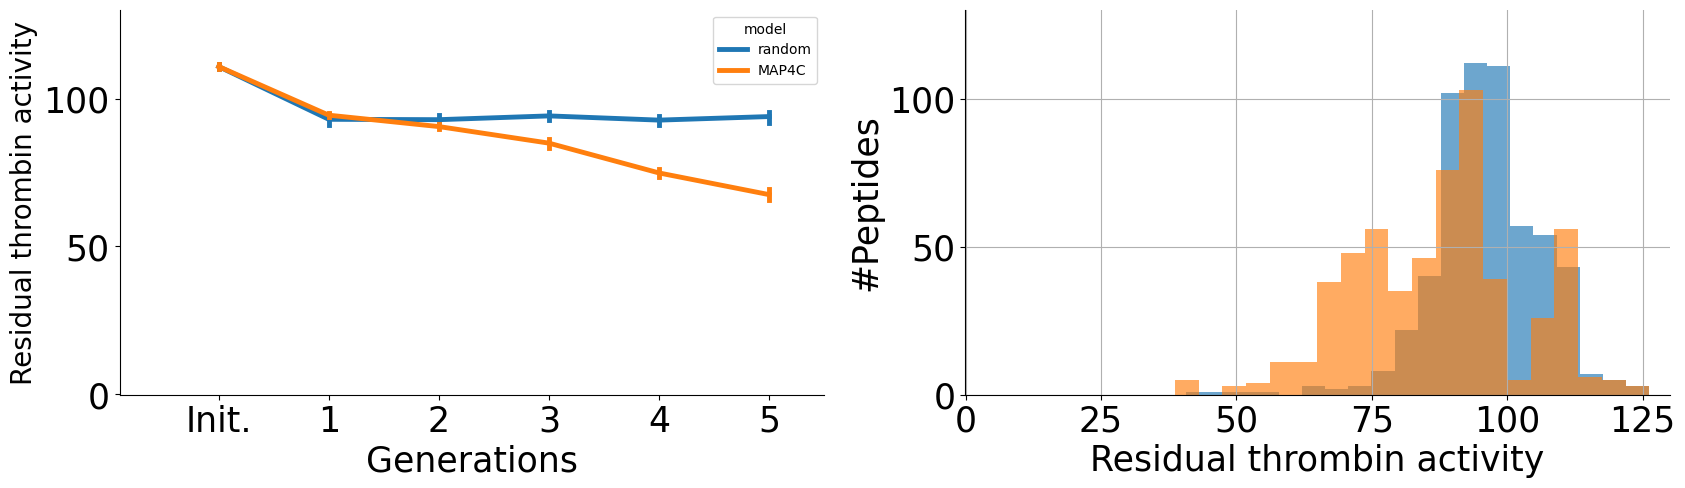

In [10]:
df_random = pd.read_csv('results_optimization_random.csv')
df = pd.read_csv('results_optimization_MAP4C_oracle.csv')
df = pd.concat([df_random, df])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-0.1, 130])
ax[0].set_ylabel('Residual thrombin activity', fontsize=20)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'MAP4C']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-0.1, 130])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Residual thrombin activity', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()